In [42]:
cd /home/ec2-user/SageMaker/VIP-Dementia/audio_processing

/home/ec2-user/SageMaker/VIP-Dementia/audio_processing


In [43]:
import os
import pandas as pd
import librosa
import opensmile
from tqdm import tqdm

# Assuming the directory setup remains unchanged
HOME_DIRECTORY = os.path.expanduser("~/SageMaker/VIP-Dementia")
RAW_DATA_DIR = os.path.join(HOME_DIRECTORY, 'data/raw')
PROCESSED_DATA_DIR = os.path.join(HOME_DIRECTORY, 'data/processed')
FEATURES_DIR = os.path.join(PROCESSED_DATA_DIR, 'features')
LABELS_DIR = os.path.join(PROCESSED_DATA_DIR, 'labels')

# Label mapping for binary classification
label_dict = {'CN': 0, 'AD': 1}

def get_features(audio_path, sample_rate):
    """
    Extract features for the entire audio file at a specified sampling rate.

    :param audio_path: Path to the audio file.
    :param sample_rate: Desired sampling rate (in Hz).
    :return: DataFrame containing extracted features.
    """
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.eGeMAPS,
        feature_level=opensmile.FeatureLevel.Functionals,
    )

    try:
        # Load the entire audio file at the specified sampling rate
        y, sr = librosa.load(audio_path, sr=sample_rate)
        # Extract features using OpenSMILE
        features_df = smile.process_signal(y, sr)
        return features_df
    except Exception as e:
        print(f"Error processing file {audio_path}: {e}")
        return pd.DataFrame()

def load_audio_data(sample_rate):
    X, y = [], []
    partitions = ['ad', 'cn']
    total_ad_files = len([name for name in os.listdir(os.path.join(RAW_DATA_DIR, 'audio', 'ad')) if name.endswith('.wav')])
    total_cn_files = len([name for name in os.listdir(os.path.join(RAW_DATA_DIR, 'audio', 'cn')) if name.endswith('.wav')])
    total_files = total_ad_files + total_cn_files
    processed_count = 0

    for partition in partitions:
        audio_dir = os.path.join(RAW_DATA_DIR, 'audio', partition)
        audio_files = [os.path.join(audio_dir, f) for f in os.listdir(audio_dir) if f.endswith('.wav')]
        
        # Using tqdm to display progress
        with tqdm(total=len(audio_files), desc=f"Processing {partition.upper()} files") as pbar:
            for audio_path in audio_files:
                features_df = get_features(audio_path, sample_rate)
                if not features_df.empty:
                    X.append(features_df)
                    y.append(label_dict[partition.upper()])
                processed_count += 1
                pbar.update(1)

    print(f"\nFinished loading audio data. Successfully processed {processed_count} audio files out of {total_files} files.")
    return X, y

In [3]:
X, y = load_audio_data(sample_rate=8000) 

Processing AD files:   0%|          | 0/87 [00:00<?, ?it/s]/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/opensmile/core/smile.py:251: UserWarning: Feature set 'FeatureSet.eGeMAPS' is deprecated, consider switching to 'FeatureSet.eGeMAPSv02'.
  warnings.warn(
Processing AD files:   1%|          | 1/87 [00:06<08:47,  6.14s/it]/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/opensmile/core/smile.py:251: UserWarning: Feature set 'FeatureSet.eGeMAPS' is deprecated, consider switching to 'FeatureSet.eGeMAPSv02'.
  warnings.warn(
Processing AD files:   2%|▏         | 2/87 [00:08<05:21,  3.79s/it]/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/opensmile/core/smile.py:251: UserWarning: Feature set 'FeatureSet.eGeMAPS' is deprecated, consider switching to 'FeatureSet.eGeMAPSv02'.
  warnings.warn(
Processing AD files:   3%|▎         | 3/87 [00:11<05:08,  3.68s/it]/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/opensmile/


Finished loading audio data. Successfully processed 166 audio files out of 166 files.


In [4]:
from sklearn.model_selection import train_test_split


features_df = pd.concat(X, ignore_index=True)
labels_series = pd.Series(y)
print(f'\nAudio samples represented: {len(X)}')  # Total number of audio files processed
print(f'Numerical features extracted per sample: {features_df.shape[1]}')
print(f'Unique labels in dataset: {labels_series.unique()}')

# Display the first few rows of the features DataFrame to check the data
features_df.head()

# Assuming 'features_df' and 'labels_series' are already defined and contain all your data
X = features_df
y = labels_series

# First, split into a training and a temp set (combining validation and test) with an 80/20 split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Then split the temp set equally into validation and test sets
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Display sizes of the datasets
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_valid.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")



Audio samples represented: 166
Numerical features extracted per sample: 88
Unique labels in dataset: [1 0]
Training set size: 132
Validation set size: 17
Test set size: 17


In [5]:
import numpy as np

# Specify the directory where you want to save the files
HOME_DIRECTORY = os.path.expanduser("~/SageMaker/VIP-Dementia")
save_dir = os.path.join(HOME_DIRECTORY, 'data/processed')

# Function to save datasets
def save_dataset(filename, dataset):
    path = os.path.join(save_dir, filename)
    np.save(path, dataset)
    print(f"Saved {filename} to {save_dir}")

# Saving each dataset
save_dataset('X_train.npy', X_train)
save_dataset('X_valid.npy', X_valid)
save_dataset('X_test.npy', X_test)
save_dataset('y_train.npy', y_train)
save_dataset('y_valid.npy', y_valid)
save_dataset('y_test.npy', y_test)


Saved X_train.npy to /home/ec2-user/SageMaker/VIP-Dementia/data/processed
Saved X_valid.npy to /home/ec2-user/SageMaker/VIP-Dementia/data/processed
Saved X_test.npy to /home/ec2-user/SageMaker/VIP-Dementia/data/processed
Saved y_train.npy to /home/ec2-user/SageMaker/VIP-Dementia/data/processed
Saved y_valid.npy to /home/ec2-user/SageMaker/VIP-Dementia/data/processed
Saved y_test.npy to /home/ec2-user/SageMaker/VIP-Dementia/data/processed


In [44]:
import os
import numpy as np

# Specify the directory where you want to save the files
HOME_DIRECTORY = os.path.expanduser("~/SageMaker/VIP-Dementia")
save_dir = os.path.join(HOME_DIRECTORY, 'data/processed/eGeMAPS/8000')
# save_dir = os.path.join(HOME_DIRECTORY, 'data/processed/16000')
SPLIT_DATA_DIR = save_dir

# Function to load datasets
def load_dataset(filename):
    path = os.path.join(SPLIT_DATA_DIR, filename)
    if os.path.exists(path):
        return np.load(path, allow_pickle=True)
    else:
        print(f"File {filename} not found in {SPLIT_DATA_DIR}. Please check the directory and try again.")
        return None

# Loading each dataset
X_train = load_dataset('X_train.npy')
X_valid = load_dataset('X_valid.npy')
X_test = load_dataset('X_test.npy')
y_train = load_dataset('y_train.npy')
y_valid = load_dataset('y_valid.npy')
y_test = load_dataset('y_test.npy')

# Verifying the shapes of the loaded datasets (if they were successfully loaded)
if X_train is not None and y_train is not None:
    print(f"Loaded X_train: {X_train.shape}, y_train: {y_train.shape}")
if X_valid is not None and y_valid is not None:
    print(f"Loaded X_valid: {X_valid.shape}, y_valid: {y_valid.shape}")
if X_test is not None and y_test is not None:
    print(f"Loaded X_test: {X_test.shape}, y_test: {y_test.shape}")


Loaded X_train: (132, 88), y_train: (132,)
Loaded X_valid: (17, 88), y_valid: (17,)
Loaded X_test: (17, 88), y_test: (17,)


In [45]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

models = {
    "Random Forest": RandomForestClassifier(),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": lgb.LGBMClassifier()
}

In [ ]:
model_outputs = {}
for name, model in models.items():
    model.fit(X_train, y_train)  # Train model
    probs = model.predict_proba(X_test)[:, 1]
    preds = model.predict(X_test)
    model_outputs[name] = (probs, preds)
print("All models trained and predictions stored.")

In [48]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import pandas as pd

def get_roc_curve(y_test, probs, model_name, color):
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, linestyle='-', color=color, label=f'{model_name}', linewidth=0.7)
    plt.xlabel('False Positive Rate', fontsize=8)
    plt.ylabel('True Positive Rate', fontsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.legend(loc='lower right', fontsize=8)

def get_confusion_matrix(y_test, y_pred, class_names, model_name):
    cm = confusion_matrix(y_test, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  
    
    fig, ax = plt.subplots(figsize=(8, 6)) 
    sns.heatmap(cm_percent, annot=True, fmt=".2%", cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def get_performance_metrics(y_test, model_outputs):
    metrics = {
        'Model': [],
        'Accuracy (%)': [],
        'Precision (%)': [],
        'Recall (%)': [],
        'F1-score (%)': []
    }

    for name, outputs in model_outputs.items():
        y_pred = outputs[1]
        metrics['Model'].append(name)
        metrics['Accuracy (%)'].append(100 * accuracy_score(y_test, y_pred))
        metrics['Precision (%)'].append(100 * precision_score(y_test, y_pred, average="macro"))
        metrics['Recall (%)'].append(100 * recall_score(y_test, y_pred, average="macro"))
        metrics['F1-score (%)'].append(100 * f1_score(y_test, y_pred, average="macro"))

    results_df = pd.DataFrame(metrics)
    return results_df

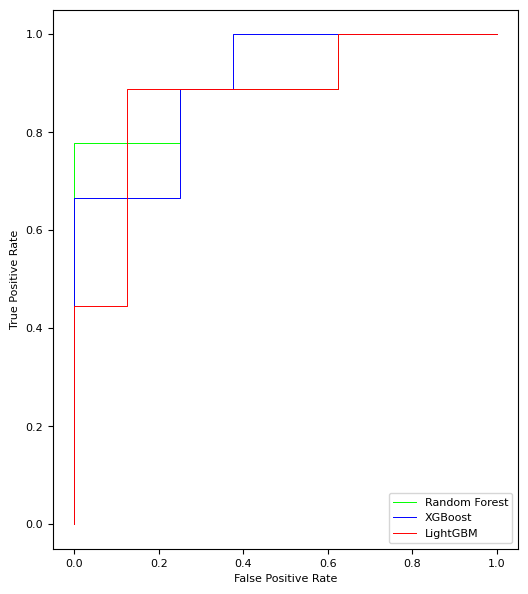

In [49]:
plt.figure(figsize=(6, 7))
colors = {'Random Forest': '#00FF00', 'XGBoost': '#0000FF', 'LightGBM': '#FF0000'}

for name, outputs in model_outputs.items():
    get_roc_curve(y_test, outputs[0], name, colors[name])

plt.show()

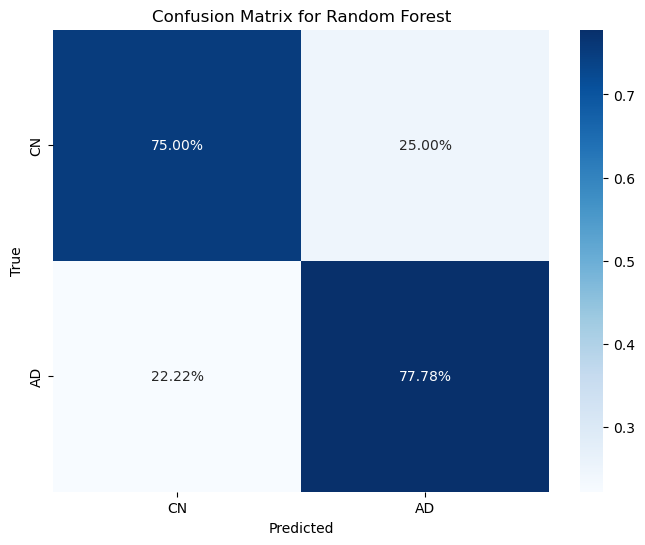

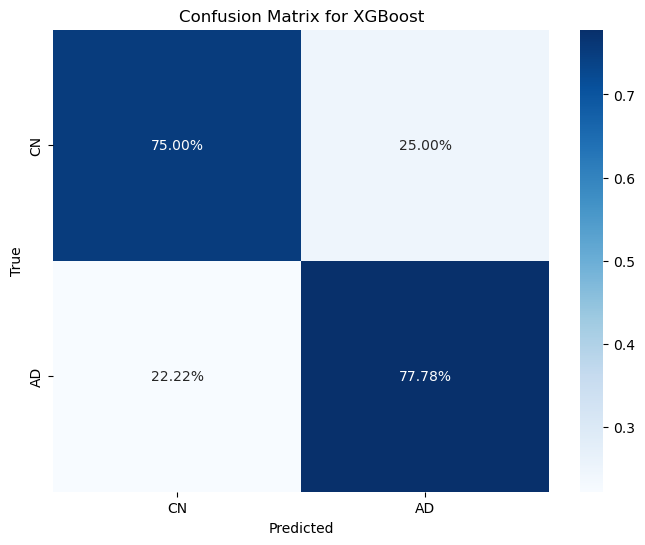

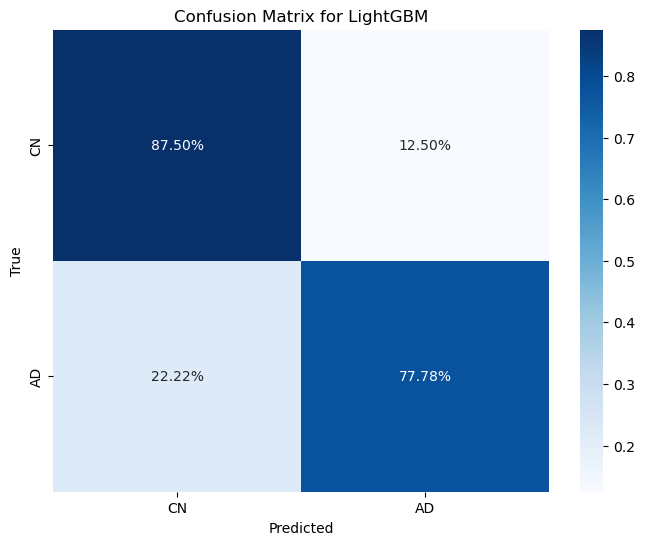

In [50]:
class_names = ['CN', 'AD']

for name, outputs in model_outputs.items():
    get_confusion_matrix(y_test, outputs[1], class_names, name)

In [51]:
results_df = get_performance_metrics(y_test, model_outputs)
print(results_df)

           Model  Accuracy (%)  Precision (%)  Recall (%)  F1-score (%)
0  Random Forest     76.470588      76.388889   76.388889     76.388889
1        XGBoost     76.470588      76.388889   76.388889     76.388889
2       LightGBM     82.352941      82.638889   82.638889     82.352941


In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import xgboost as xgb
import lightgbm as lgb # light XGBoost package

classification_models = [
    KNeighborsClassifier(),
    SVC(kernel='linear'),
    SVC(kernel='rbf'),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    xgb.XGBClassifier(),
    lgb.LGBMClassifier(verbosity=-1)
 
]

scores = []
for model in classification_models:
    try:
        model.fit(X_train, y_train)
        score = model.score(X_test, y_test)
        model_name = type(model).__name__
        if isinstance(model, SVC) and model.kernel == 'rbf':
            model_name += ' RBF kernel'
        scores.append((model_name, f'{100*score:.2f}%'))
    except ValueError as e:
        print(f"Error training {type(model).__name__}: {str(e)}")


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [9]:
# Make it pretty
scores_df = pd.DataFrame(scores,columns=['Classifier','Accuracy Score'])
scores_df.sort_values(by='Accuracy Score',axis=0,ascending=False)

,Classifier,Accuracy Score
3,DecisionTreeClassifier,82.35%
5,AdaBoostClassifier,82.35%
9,LGBMClassifier,82.35%
0,KNeighborsClassifier,76.47%
4,RandomForestClassifier,76.47%
8,XGBClassifier,76.47%
1,SVC,64.71%
6,GaussianNB,64.71%
2,SVC RBF kernel,52.94%
7,QuadraticDiscriminantAnalysis,41.18%


## RandomForest Analysis

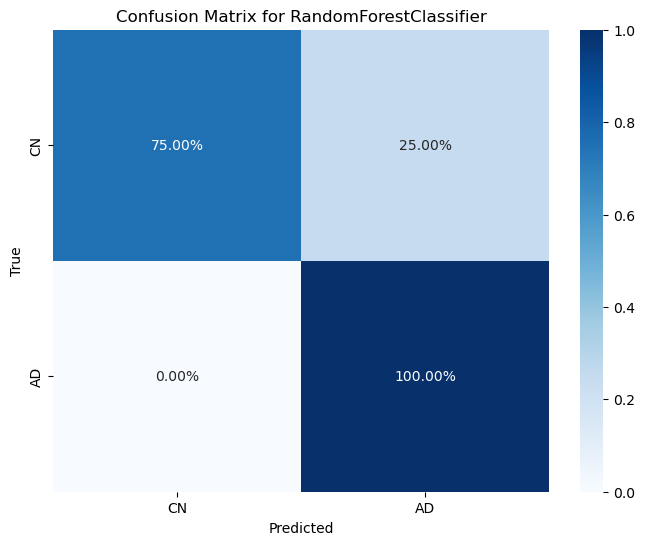

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

def plot_confusion_matrix(clf, X_test, y_test, class_names):
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Convert counts to percentage
    
    fig, ax = plt.subplots(figsize=(8, 6))  # Larger figure size for better readability
    sns.heatmap(cm_percent, annot=True, fmt=".2%", cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
    plt.title(f'Confusion Matrix for {type(clf).__name__}')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.show()

# Example usage with class names
class_names = ['CN', 'AD']  # Ensure class names are in the order of your actual labels
plot_confusion_matrix(RandomForestClassifier().fit(X_train, y_train), X_test, y_test, class_names)


In [11]:
from sklearn.ensemble import RandomForestClassifier

####### Default Random Forest ########
model = RandomForestClassifier(
    random_state=69
)

model.fit(X_train, y_train)

print(f'Default Random Forest Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Default Random Forest Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%\n')


########## Tuned Random Forest #######
model = RandomForestClassifier(
    n_estimators = 500, 
    criterion ='entropy',
    warm_start = True,
    max_features = 'sqrt',
    oob_score = 'True', # more on this below
    random_state=69  
) 

model.fit(X_train, y_train)

print(f'Random Forest Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Random Forest Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')

Default Random Forest Model's accuracy on training set is 100.00%
Default Random Forest Model's accuracy on test set is 94.12%



InvalidParameterError: The 'oob_score' parameter of RandomForestClassifier must be an instance of 'bool' or an instance of 'numpy.bool_' or a callable. Got 'True' instead.

## MLP Analysis

In [13]:
from sklearn.neural_network import MLPClassifier

# Default 'off-the-shelf' MLP from sklearn
model = MLPClassifier(
    random_state = 69
)

#################### unscaled features #####################


model.fit(X_train, y_train)

print(f'Possible emotions predicted by model:{model.classes_}')
print(f'Unscaled MLP Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Unscaled MLP Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')

Possible emotions predicted by model:[0 1]
Unscaled MLP Model's accuracy on training set is 68.94%
Unscaled MLP Model's accuracy on test set is 70.59%


In [14]:
from sklearn.model_selection import GridSearchCV

# Initialize the MLP Classifier and choose parameters we want to keep constant
model = MLPClassifier(
    # tune batch size later 
    batch_size=256,  
    # keep random state constant to accurately compare subsequent models
    random_state=69
)

# Choose the grid of hyperparameters we want to use for Grid Search to build our candidate models
parameter_space = {
    # A single hidden layer of size between 8 (output classes) and 180 (input features) neurons is most probable
    # It's a bad idea at guessing the number of hidden layers to have
    # ...but we'll give 2 and 3 hidden layers a shot to reaffirm our suspicions that 1 is best
    'hidden_layer_sizes': [(8,), (180,), (300,),(100,50,),(10,10,10)], 
    'activation': ['tanh','relu', 'logistic'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'epsilon': [1e-08, 0.1 ],
    'learning_rate': ['adaptive', 'constant']
}
   
# Create a grid search object which will store the scores and hyperparameters of all candidate models 
grid = GridSearchCV(
    model, 
    parameter_space,
    cv=10,
    n_jobs=4)
# Fit the models specified by the parameter grid 
grid.fit(X_train, y_train)

# get the best hyperparameters from grid search object with its best_params_ attribute
print('Best parameters found:\n', grid.best_params_)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packag

Best parameters found:
 {'activation': 'logistic', 'alpha': 0.0001, 'epsilon': 1e-08, 'hidden_layer_sizes': (300,), 'learning_rate': 'adaptive', 'solver': 'sgd'}


## Light GBM Analysis

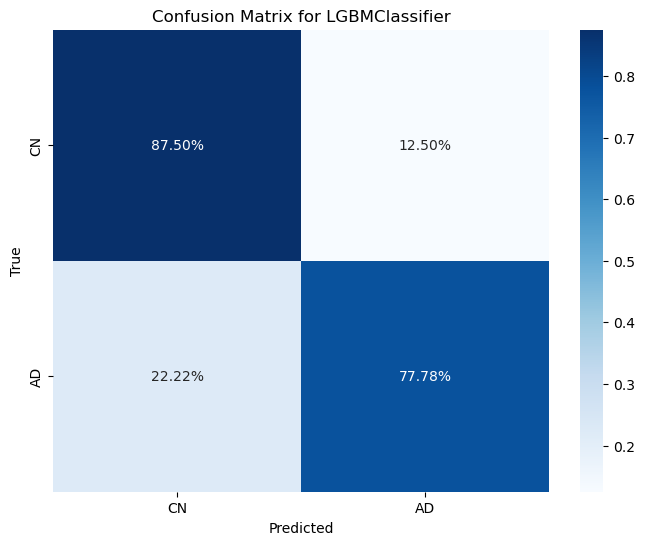

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import lightgbm as lgb # light XGBoost package

def plot_confusion_matrix(clf, X_test, y_test, class_names):
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Convert counts to percentage
    
    fig, ax = plt.subplots(figsize=(8, 6))  # Larger figure size for better readability
    sns.heatmap(cm_percent, annot=True, fmt=".2%", cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
    plt.title(f'Confusion Matrix for {type(clf).__name__}')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.show()

# Example usage with class names
class_names = ['CN', 'AD']  # Ensure class names are in the order of your actual labels
plot_confusion_matrix(lgb.LGBMClassifier(verbosity=-1).fit(X_train, y_train), X_test, y_test, class_names)

In [11]:
####### Default LGBM ########
model = lgb.LGBMClassifier(
    verbosity=-1,
    random_state=69
)


model.fit(X_train, y_train)

print(f'Default LGBM\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Default LGBM\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%\n')


########## Tuned LGBM #######

params = {
    'application': 'binary', # for binary classification
#     'num_class' : 1, # used for multi-classes
    'boosting': 'gbdt', # traditional gradient boosting decision tree
    'num_iterations': 100, 
    'learning_rate': 0.05,
    'num_leaves': 62,
    'device': 'cpu', # you can use GPU to achieve faster learning
    'max_depth': -1, # <0 means no limit
    'max_bin': 510, # Small number of bins may reduce training accuracy but can deal with over-fitting
    'lambda_l1': 5, # L1 regularization
    'lambda_l2': 10, # L2 regularization
    'metric' : 'binary_error',
    'subsample_for_bin': 200, # number of samples for constructing bins
    'subsample': 1, # subsample ratio of the training instance
    'colsample_bytree': 0.8, # subsample ratio of columns when constructing the tree
    'min_split_gain': 0.5, # minimum loss reduction required to make further partition on a leaf node of the tree
    'min_child_weight': 1, # minimum sum of instance weight (hessian) needed in a leaf
    'min_child_samples': 5# minimum number of data needed in a leaf
}

# Initiate classifier to use
tuned_model = lgb.LGBMClassifier(boosting_type= 'gbdt', 
          objective = 'binary', 
          n_jobs = 5, 
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'], 
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'], 
          min_split_gain = params['min_split_gain'], 
          min_child_weight = params['min_child_weight'], 
          min_child_samples = params['min_child_samples'],
          verbosity=-1)

tuned_model.fit(X_train, y_train)

print(f'Tuned LGBM\'s accuracy on training set is {100*tuned_model.score(X_train, y_train):.2f}%')
print(f'Tuned LGBM\'s accuracy on test set is {100*tuned_model.score(X_test, y_test):.2f}%')

Default LGBM's accuracy on training set is 100.00%
Default LGBM's accuracy on test set is 82.35%

Tuned LGBM's accuracy on training set is 100.00%
Tuned LGBM's accuracy on test set is 88.24%


In [12]:
from sklearn.model_selection import GridSearchCV

gridParams = {
    'learning_rate': [0.005, 0.01],
    'n_estimators': [8,16,24],
    'num_leaves': [6,8,12,16], # large num_leaves helps improve accuracy but might lead to over-fitting
    'boosting_type' : ['gbdt', 'dart'], # for better accuracy -> try dart
    'objective' : ['binary'],
    'max_bin':[255, 510], # large max_bin helps improve accuracy but might slow down training progress
    'random_state' : [500],
    'colsample_bytree' : [0.64, 0.65, 0.66],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
    }

grid = GridSearchCV(model, gridParams, verbose=1, cv=4, n_jobs=-1)
# Run the grid
grid.fit(X_train, y_train)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

Fitting 4 folds for each of 3456 candidates, totalling 13824 fits
{'boosting_type': 'dart', 'colsample_bytree': 0.65, 'learning_rate': 0.01, 'max_bin': 255, 'n_estimators': 16, 'num_leaves': 6, 'objective': 'binary', 'random_state': 500, 'reg_alpha': 1.2, 'reg_lambda': 1.4, 'subsample': 0.7}
0.5757575757575757


In [27]:
params['colsample_bytree'] = grid.best_params_['colsample_bytree']
params['learning_rate'] = grid.best_params_['learning_rate'] 
params['max_bin'] = grid.best_params_['max_bin']
params['num_leaves'] = grid.best_params_['num_leaves']
params['reg_alpha'] = grid.best_params_['reg_alpha']
params['reg_lambda'] = grid.best_params_['reg_lambda']
params['subsample'] = grid.best_params_['subsample']

params

{'application': 'binary',
 'boosting': 'gbdt',
 'num_iterations': 100,
 'learning_rate': 0.01,
 'num_leaves': 6,
 'device': 'cpu',
 'max_depth': -1,
 'max_bin': 255,
 'lambda_l1': 5,
 'lambda_l2': 10,
 'metric': 'binary_error',
 'subsample_for_bin': 200,
 'subsample': 0.7,
 'colsample_bytree': 0.65,
 'min_split_gain': 0.5,
 'min_child_weight': 1,
 'min_child_samples': 5,
 'reg_alpha': 1.2,
 'reg_lambda': 1.4}

In [29]:
# Initiate classifier to use
grid_model = lgb.LGBMClassifier(boosting_type= 'dart', 
          objective = 'binary', 
          n_jobs = 5, 
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'], 
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'], 
          min_split_gain = params['min_split_gain'], 
          min_child_weight = params['min_child_weight'], 
          min_child_samples = params['min_child_samples'],
          verbosity=-1)

grid_model.fit(X_train, y_train)

print(f'Tuned LGBM\'s accuracy on training set is {100*grid_model.score(X_train, y_train):.2f}%')
print(f'Tuned LGBM\'s accuracy on test set is {100*grid_model.score(X_test, y_test):.2f}%')

Tuned LGBM's accuracy on training set is 100.00%
Tuned LGBM's accuracy on test set is 88.24%
